In [1]:
# paths
path_no_replay_old= "/home/anton/src/cl-lora/baseline/log/pytorch_job_20250527_012007.log"
path_replay_old = "/home/anton/src/cl-lora/baseline/log/pytorch_job_20250527_140004.log"
path_no_replay_lora_check ="/home/anton/src/cl-lora/baseline/log/pytorch_job_20250527_192454.log"
path_no_replay_med_ss="/home/anton/src/cl-lora/baseline/log/pytorch_job_20250528_140456.log"
path_no_replay_big_ss="/home/anton/src/cl-lora/baseline/log/pytorch_job_20250530_111010.log"
path_softcon_no_replay="/home/anton/src/cl-lora/baseline/softcon_continual_ft.log"
path_softcon_replay = "/home/anton/src/cl-lora/baseline/softcon_ft_from_scratch.log"

In [2]:
import ast

def load_results_from_file(path):
    """
    Reads a log file and extracts all RESULT dicts for plotting.

    Parameters
    ----------
    path : str
        Path to the text file containing lines like:
        "2025-05-27 19:38:48,484 INFO Result: {'step': 1, ...}"

    Returns
    -------
    List[dict]
        A list of dictionaries parsed from each "INFO Result:" line,
        sorted by their 'step' field.
    """
    results = []
    with open(path, 'r') as f:
        for line in f:
            if 'INFO Result:' in line:
                # split off the Python-literal dict
                _, payload = line.split('INFO Result:', 1)
                try:
                    # parse the payload into a dict
                    data = ast.literal_eval(payload.strip())
                    results.append(data)
                except (SyntaxError, ValueError) as e:
                    # skip malformed lines
                    print(f"Warning: could not parse line: {e}")
    # ensure ordering by step
    results.sort(key=lambda d: d.get('step', 0))
    return results

In [3]:

def load_results_from_file(path, encodings=('utf-8', 'latin-1'), errors='ignore'):
    """
    Attempts to read a log file containing lines with "INFO Result: {<dict>}"
    and returns a list of Python dicts parsed from those lines.

    - path: path to the log file
    - encodings: tuple of encodings to try (in order) until one succeeds
    - errors: how to handle decoding errors (default 'ignore'; could also use 'replace')

    Returns: list of dicts
    """
    for enc in encodings:
        try:
            results = []
            with open(path, 'r', encoding=enc, errors=errors) as f:
                for line in f:
                    if 'INFO Result:' in line:
                        # Split off the Python-literal dict after "INFO Result:"
                        _, payload = line.split('INFO Result:', 1)
                        payload = payload.strip()
                        if payload:
                            try:
                                # Safely evaluate the dict literal
                                result_dict = ast.literal_eval(payload)
                                if isinstance(result_dict, dict):
                                    results.append(result_dict)
                            except (ValueError, SyntaxError):
                                # Skip lines that aren't valid dict literals
                                continue
            return results
        except (UnicodeDecodeError, FileNotFoundError):
            # Try the next encoding if there's a Unicode issue,
            # or re-raise if the file doesn't exist
            if isinstance(_, FileNotFoundError):
                raise
            continue

    # If none of the encodings worked, raise an error
    raise UnicodeDecodeError(f"Unable to decode {path} with encodings {encodings}")

In [4]:
import ast
import re

# compiled once – catches np.float32/64 and np.int32/64
_NUMPY_WRAPPER = re.compile(r'np\.(?:float|int)\d+\(([^)]+)\)')

def load_results_from_file(path, encodings=('utf-8', 'latin-1'), errors='ignore'):
    """
    Read a log file that contains lines like
        YYYY-mm-dd hh:mm:ss,sss INFO Result: {<dict>}
    and return the list of dicts.

    Lines whose payload cannot be parsed are skipped.
    """
    for enc in encodings:
        try:
            results = []

            with open(path, encoding=enc, errors=errors) as f:
                for line in f:
                    if 'INFO Result:' not in line:
                        continue

                    # everything after the marker is the dict literal
                    payload = line.split('INFO Result:', 1)[1].strip()

                    # drop wrappers such as  np.float64(...)
                    payload = _NUMPY_WRAPPER.sub(r'\1', payload)

                    try:
                        obj = ast.literal_eval(payload)
                        if isinstance(obj, dict):
                            results.append(obj)
                    except (ValueError, SyntaxError):
                        # silently ignore malformed lines
                        continue

            return results

        except FileNotFoundError:           # real problem – propagate
            raise
        except UnicodeDecodeError:          # try next encoding
            continue

    raise UnicodeDecodeError(
        f"Unable to decode {path!s} with encodings {encodings}"
    )

In [5]:
import matplotlib.pyplot as plt
import os
def plot_accuracies_from_first(
    results,
    metric,
    figsize=(10, 6),
    title=None,
    save_path=None,
    dpi=300,
):
    """
    Plots mean accuracy across all steps, and for each country
    only from the step it first appears.

    Parameters
    ----------
    results : list of dict
        Each dict must have at least:
          - 'step'
          - 'mean_<metric>'
          - '<Country>_<metric>' entries for whichever countries have
            appeared up to that step.
    metric : str
        The metric to plot (e.g., 'accuracy', 'macro_ap', 'micro_ap').
    figsize : tuple, default (10, 6)
        Figure size in inches.
    title : str or None, default None
        Custom title for the plot. If None, defaults to the metric name.
    save_path : str or None, default None
        If provided, the plot will be saved to this file path (e.g., 'plot.png').
    dpi : int, default 300
        Dots per inch for the saved figure (only used if save_path is not None).

    Usage
    -----
    # Basic usage with default title and no saving:
    plot_accuracies_from_first(results, 'accuracy')

    # Custom title and save to disk:
    plot_accuracies_from_first(
        results,
        'accuracy',
        title='Model Accuracy Over Time',
        save_path='accuracy_plot.png'
    )
    """
    # 1) Extract and plot mean metric
    steps = [r['step'] for r in results]
    mean_vals = [r[f'mean_{metric}'] for r in results]

    plt.figure(figsize=figsize)
    plt.plot(
        steps,
        mean_vals,
        marker='o',
        linewidth=2,
        #label=f'Mean {metric}',
        label="Mean",#f'Mean micro aP',
        color='black'
    )

    # 2) Gather per‐country (step, value) pairs
    country_data = {}
    suffix = f'_{metric}'
    for r in results:
        step = r['step']
        for key, val in r.items():
            if key.endswith(suffix) and key != f'mean{suffix}':
                country = key[: -len(suffix)]
                country_data.setdefault(country, []).append((step, val))

    # 3) Plot each country starting at its first step
    for country, pairs in country_data.items():
        xs, ys = zip(*pairs)  # unpack steps & values
        plt.plot(xs, ys, marker='o', linestyle='--', label=country)

    # 4) Final styling
    plt.xlabel('Task')
    plt.ylabel("aP")
    #plt.ylabel("micro aP")
    plt.title(title if title is not None else metric)
    plt.xticks(steps)

    if metric == 'accuracy':
        plt.ylim(70, 100)
    elif metric == 'macro_ap':
        plt.ylim(0.1, 0.5)
    elif metric == 'micro_ap':
        plt.ylim(0, 1)

    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend(loc='best')
    plt.tight_layout()


    # 5) Save the figure if requested (create missing directories first)
    if save_path:
        # Extract the directory portion of the path
        folder = os.path.dirname(save_path)
        if folder and not os.path.exists(folder):
            os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()

    plt.show()

In [6]:
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator   # <-- NEW

def plot_train_times(results, figsize=(10, 6), save_path=None, dpi=300):
    """
    Plots the training time for each task/step with a dotted background grid.

    Parameters
    ----------
    results : list[dict]
        Each dict must contain:
          - 'step'         : task/step identifier
          - 'train_time_s' : training time in seconds
    figsize : tuple, default (10, 6)
        Size of the figure in inches.
    save_path : str or None
        If provided, saves the plot to this path.
    dpi : int, default 300
        Resolution for the saved figure.
    """
    # -------- data --------
    steps       = [r['step']         for r in results]
    train_times = [r['train_time_s'] for r in results]

    # -------- figure & axes --------
    fig, ax = plt.subplots(figsize=figsize, facecolor="white")
    ax.set_facecolor("white")

    # bars
    ax.bar(steps, train_times, color="skyblue")

    # axes labelling
    ax.set_xlabel("Task")
    ax.set_ylabel("Train Time (s)")
    ax.set_title("Training Time per Task")
    ax.set_xticks(steps)

    # ---- dotted grid that stops at frame ----
    ax.set_axisbelow(True)          # grid behind data
    ax.minorticks_on()              # minor ticks so "both" works
    ax.grid(True, which='major',
            linestyle=':', linewidth=0.9,
            color='gray', alpha=0.8)

    # ---- solid black frame around plot ----
    for side in ['top', 'right', 'bottom', 'left']:
        spine = ax.spines[side]
        spine.set_visible(True)     # make sure top & right are shown
        spine.set_color('black')
        spine.set_linewidth(1)    # slightly thicker than default

    ax.legend(loc='best')
    fig.tight_layout()

    # -------- optional save --------
    if save_path:
        folder = os.path.dirname(save_path)
        if folder and not os.path.exists(folder):
            os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight", facecolor="white")

    plt.show()

In [7]:
# metrics
a = 'accuracy'
ma = 'macro_ap'
mi = 'micro_ap'

In [ ]:
#rank 4 no replay
res = load_results_from_file(path_no_replay_med_ss)
plot_accuracies_from_first(res, mi,title="Macro aP for Finetuning from Scratch on SoftCon")

In [ ]:
#rank 8 no replay
r8_path = "/home/anton/src/cl-lora/baseline/log/epoch15/rank8_no_replay_0123.log"
res = load_results_from_file(r8_path)
plot_accuracies_from_first(res, mi,title="Macro aP for Finetuning from Scratch on SoftCon")

In [ ]:
#rank 4 no replay
path_test= "/home/anton/src/cl-lora/baseline/log/pytorch_job_20250601_201501.log"

res = load_results_from_file(path_test)
plot_accuracies_from_first(res, mi,title="Macro aP for Finetuning from Scratch on SoftCon")

In [ ]:
#rank 8 no replay
r8_path = "/home/anton/src/cl-lora/baseline/log/epoch15/rank8_replay_0123.log"
res = load_results_from_file(r8_path)
plot_accuracies_from_first(res, mi,title="Macro aP for Finetuning from Scratch on SoftCon")

In [ ]:
# Softcon
res = load_results_from_file(path_softcon_replay)
plot_accuracies_from_first(res, ma,title="Macro aP for Finetuning from Scratch on SoftCon",save_path="/home/anton/src/cl-lora/img/macro_ap_ftfs_softcon.png")

In [ ]:
plot_train_times(res,save_path="/home/anton/src/cl-lora/img/times_ftfs_softcon.png")

In [ ]:
plot_accuracies_from_first(load_results_from_file(path_no_replay_big_ss),ma,title="Macro Averaged Precision on Countries Test Sets",save_path="/home/anton/src/cl-lora/img/macro_ap_big_ss.png")


In [ ]:
plot_accuracies_from_first(load_results_from_file(path_no_replay_big_ss),mi)

In [ ]:
plot_train_times(load_results_from_file(path_replay_old),metric=a)

In [ ]:
import re

def parse_epoch_losses(path, encodings=('utf-8', 'latin-1'), errors='ignore'):
    """
    Reads a log file and extracts lines of the form:
      Epoch {current}/{total}, Train Loss: {train_loss}, Val Loss: {val_loss}
    for all tasks and all epochs. Returns a list of dicts:
      [
          {
              'epoch': int,
              'total_epochs': int,
              'train_loss': float,
              'val_loss': float
          },
          ...
      ]

    Parameters
    ----------
    path : str
        Path to the log file.
    encodings : tuple of str, optional
        Encodings to try when opening the file (default: ('utf-8', 'latin-1')).
    errors : str, optional
        Error handling when decoding (default: 'ignore').

    Returns
    -------
    losses : list of dict
        Each dict contains 'epoch', 'total_epochs', 'train_loss', and 'val_loss'.
    """
    pattern = re.compile(
        r"Epoch\s+(\d+)/(\d+),\s*Train Loss:\s*([\d\.]+),\s*Val Loss:\s*([\d\.]+)"
    )
    for enc in encodings:
        try:
            losses = []
            with open(path, 'r', encoding=enc, errors=errors) as f:
                for line in f:
                    match = pattern.search(line)
                    if match:
                        epoch = int(match.group(1))
                        total_epochs = int(match.group(2))
                        train_loss = float(match.group(3))
                        val_loss = float(match.group(4))
                        losses.append({
                            'epoch': epoch,
                            'total_epochs': total_epochs,
                            'train_loss': train_loss,
                            'val_loss': val_loss
                        })
            return losses
        except (UnicodeDecodeError, FileNotFoundError):
            continue

    raise UnicodeDecodeError(f"Unable to decode {path} with encodings {encodings}")



In [ ]:
def plot_epoch_losses_continuous_with_tasks(losses, figsize=(10, 6)):
    """
    Plots training and validation loss over all epochs from all tasks as one continuous series.
    Draws dotted vertical lines where a new task starts, and labels x-axis ticks with Task-Epoch.

    Parameters
    ----------
    losses : list of dict
        Each dict must have keys:
          - 'epoch' (int): epoch number within its task
          - 'total_epochs' (int): total epochs in that task (not used directly here)
          - 'train_loss' (float)
          - 'val_loss' (float)
        The list should be ordered in the sequence the epochs were run (i.e., Task 1 epochs first,
        then Task 2 epochs, etc.).
    figsize : tuple, default (10, 6)
        Figure size in inches.
    """
    # Number of total entries
    n = len(losses)
    global_steps = list(range(1, n + 1))
    train_losses = [entry['train_loss'] for entry in losses]
    val_losses = [entry['val_loss'] for entry in losses]

    # Detect task boundaries: where epoch == 1 (new task starts), except the very first entry
    task_boundaries = [i for i, entry in enumerate(losses) if entry['epoch'] == 1 and i > 0]

    # Build Task-Epoch labels
    task_labels = []
    task_id = 1
    for i, entry in enumerate(losses):
        epoch = entry['epoch']
        if i > 0 and epoch == 1:
            task_id += 1
        task_labels.append(f"T{task_id}E{epoch}")

    plt.figure(figsize=figsize)
    plt.plot(global_steps, train_losses, marker='o', linestyle='-', label='Train Loss', color='blue')
    plt.plot(global_steps, val_losses,   marker='s', linestyle='--', label='Val Loss',   color='red')

    # Draw vertical dotted lines at task boundaries
    for boundary in task_boundaries:
        # boundary is index in losses, so x position is boundary + 0.5 (between tasks)
        plt.axvline(x=boundary + 0.5, linestyle=':', color='gray')

    plt.xlabel('Task-Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs. Validation Loss Across All Tasks (Continuous)')
    plt.xticks(global_steps, task_labels, rotation=45, ha='right')
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_epoch_losses_continuous_with_tasks(parse_epoch_losses(path_no_replay_big_ss))

In [ ]:
plot_epoch_losses_continuous_with_tasks(parse_epoch_losses(path_replay_old),figsize=(20,6))

In [ ]:
path_test= "/home/anton/src/cl-lora/baseline/log/pytorch_job_20250601_201501.log"
plot_accuracies_from_first(load_results_from_file(path_test),metric=mi,save_path="/home/anton/src/cl-lora/img/micro_ap_replay.png",title="Micro Averaged Precision on Countries Test Sets")
plot_epoch_losses_continuous_with_tasks(parse_epoch_losses(path_test))
plot_train_times(load_results_from_file(path_test))

In [ ]:
# Specify the filename
file_path = "/home/anton/src/cl-lora/img/time_replay.png"

plot_train_times(load_results_from_file(path_test),save_path=file_path)


In [ ]:
import matplotlib.pyplot as plt
import os

def plot_accuracies_from_first(
    results,
    metric,
    figsize=(10, 6),
    title=None,
    save_path=None,
    dpi=300,
):
    """
    Plots mean accuracy across all steps, and for each country
    only from the step it first appears.
    """
    # --- Figure & axes, forced-white background --------------------------------
    fig, ax = plt.subplots(figsize=figsize, facecolor="white")
    ax.set_facecolor("white")
    # --------------------------------------------------------------------------

    # 1) Extract and plot mean metric
    steps     = [r['step'] for r in results]
    mean_vals = [r[f'mean_{metric}'] for r in results]

    ax.plot(
        steps,
        mean_vals,
        marker='o',
        linewidth=2,
        label='Mean of macro aP',      # or f'Mean {metric}'
        color='black'
    )

    # 2) Gather per-country (step, value) pairs
    suffix = f'_{metric}'
    country_data = {}
    for r in results:
        step = r['step']
        for key, val in r.items():
            if key.endswith(suffix) and key != f'mean{suffix}':
                country = key[:-len(suffix)]
                country_data.setdefault(country, []).append((step, val))

    # 3) Plot each country starting at its first step
    for country, pairs in country_data.items():
        xs, ys = zip(*pairs)
        ax.plot(xs, ys, marker='o', linestyle='--', label=country)

    # -------------------- final styling ---------------------------------
    ax.set_xlabel('Task')
    ax.set_ylabel('macro aP')
    ax.set_title(title if title is not None else metric)
    ax.set_xticks(steps)

    # y-limits chosen as before
    if metric == 'accuracy':
        ax.set_ylim(70, 100)
    elif metric == 'macro_ap':
        ax.set_ylim(0.2, 0.5)
    elif metric == 'micro_ap':
        ax.set_ylim(0, 1)

    # ---- dotted grid that stops at frame ----
    ax.set_axisbelow(True)          # grid behind data
    ax.minorticks_on()              # minor ticks so "both" works
    ax.grid(True, which='major',
            linestyle=':', linewidth=0.9,
            color='gray', alpha=0.8)

    # ---- solid black frame around plot ----
    for side in ['top', 'right', 'bottom', 'left']:
        spine = ax.spines[side]
        spine.set_visible(True)     # make sure top & right are shown
        spine.set_color('black')
        spine.set_linewidth(1)    # slightly thicker than default

    ax.legend(loc='best')
    fig.tight_layout()
    # --------------------------------------------------------------------

    # 5) Save the figure if requested
    if save_path:
        folder = os.path.dirname(save_path)
        if folder and not os.path.exists(folder):
            os.makedirs(folder, exist_ok=True)
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()

In [ ]:
plot_accuracies_from_first(load_results_from_file(path_test),ma,title="Macro Averaged Precision on Countries Test Sets",save_path="/home/anton/src/cl-lora/img/macro_ap_replay.png")

In [32]:
import os
import matplotlib.pyplot as plt
import itertools

def compare_experiments(
    experiments: dict[str, list[dict]],
    metric: str,
    figsize=(10, 6),
    title=None,
    save_path=None,
    dpi=300,
    plot_countries=False,
    average: bool = True,
):
    """
    Overlay multiple experiments’ mean_<metric> (and optionally per-country)
    curves on a single plot, and optionally plot the average over all experiments.

    Parameters
    ----------
    experiments : dict
        Keys are experiment labels (str), values are lists of result-dicts
        with the same format as before.
    metric : str
        Metric to plot (e.g. 'accuracy', 'macro_ap', 'micro_ap').
    figsize : tuple
        Figure size in inches.
    title : str or None
        Plot title; defaults to metric name.
    save_path : str or None
        If set, saves the figure there.
    dpi : int
        DPI for saving.
    plot_countries : bool
        Whether to also overlay each country’s curve for each experiment.
    average : bool
        Whether to plot the average of mean_<metric> across all experiments.
    """
    plt.figure(figsize=figsize)
    cmap = plt.get_cmap('tab10')
    color_iter = itertools.cycle(cmap.colors)

    suffix = f'_{metric}'

    # accumulate values for overall average if requested
    if average:
        overall: dict[int, list[float]] = {}
        for results in experiments.values():
            for r in results:
                step = r['step']
                overall.setdefault(step, []).append(r[f'mean_{metric}'])

    # Plot each experiment
    for label, results in experiments.items():
        color = next(color_iter)
        steps = [r['step'] for r in results]
        mean_vals = [r[f'mean_{metric}'] for r in results]

        # Plot mean curve
        plt.plot(
            steps,
            mean_vals,
            marker='o',
            linewidth=2,
            label=f'{label} (mean)',
            color=color,
        )

        if plot_countries:
            # gather per-country
            country_data: dict[str, list[tuple[int, float]]] = {}
            for r in results:
                step = r['step']
                for key, val in r.items():
                    if key.endswith(suffix) and key != f'mean{suffix}':
                        country = key[:-len(suffix)]
                        country_data.setdefault(country, []).append((step, val))

            # plot each country with a lighter linestyle
            for country, pairs in country_data.items():
                xs, ys = zip(*pairs)
                plt.plot(
                    xs, ys,
                    marker='o',
                    linestyle='--',
                    label=f'{label} — {country}',
                    color=color,
                    alpha=0.6
                )

    # Plot overall average if requested
    if average:
        avg_steps = sorted(overall)
        avg_vals = [sum(overall[s]) / len(overall[s]) for s in avg_steps]
        plt.plot(
            avg_steps,
            avg_vals,
            marker='s',
            linewidth=2,
            linestyle='-',
            label='Overall Average',
            color='black'
        )

    plt.xlabel('Task')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(title or metric.title())
    # set y-limits intelligently
    if metric == 'accuracy':
        plt.ylim(70, 100)
    elif metric in ('macro_ap', 'micro_ap'):
        plt.ylim(0, 1)

    # unify x-ticks across all experiments
    all_steps = sorted({r['step'] for results in experiments.values() for r in results})
    plt.xticks(all_steps)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend(loc='best', fontsize='small')
    plt.tight_layout()

    if save_path:
        folder = os.path.dirname(save_path)
        if folder and not os.path.exists(folder):
            os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()

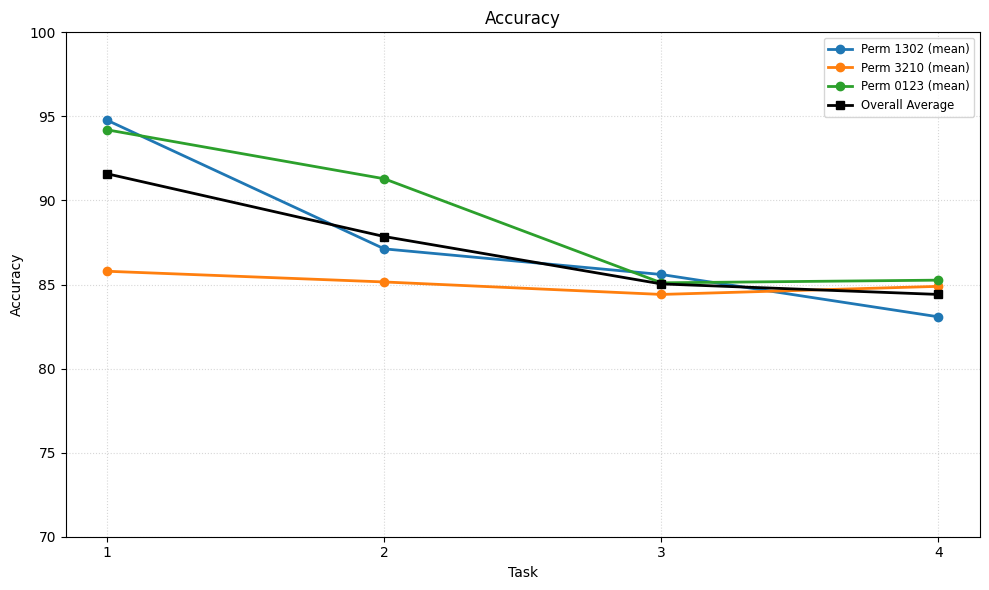

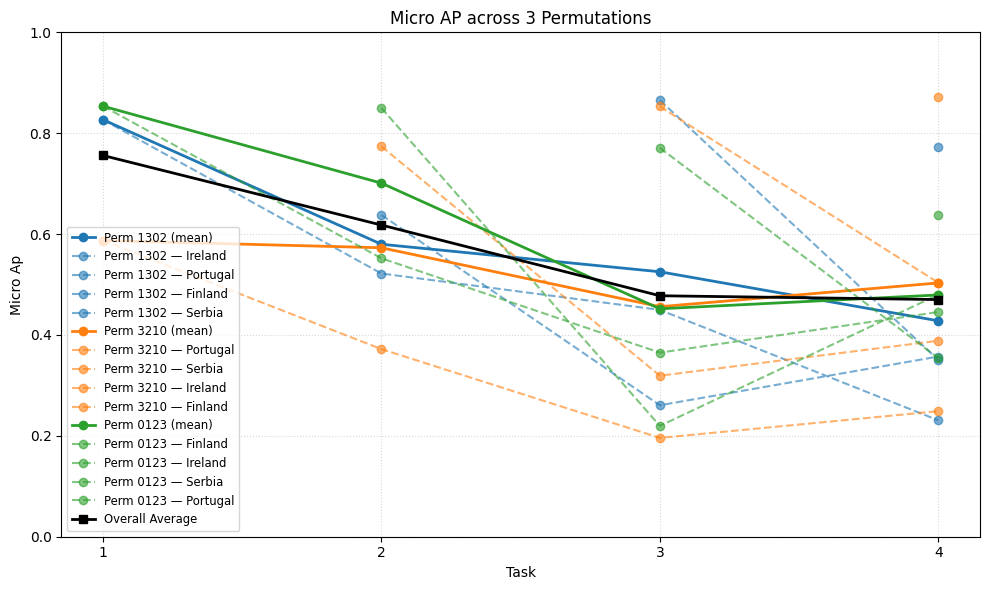

In [28]:
# suppose you ran three different task‐permutation experiments and stored
# their results lists in exp1_results, exp2_results, exp3_results.

experiments = {
    'Perm 1302': load_results_from_file("/home/anton/src/cl-lora/baseline/log/epoch15/no_replay_1302.log"),
    'Perm 3210': load_results_from_file("/home/anton/src/cl-lora/baseline/log/epoch15/no_replay_3210.log"),
    'Perm 0123': load_results_from_file("/home/anton/src/cl-lora/baseline/log/epoch15/no_replay_0123.log"),


}
#     'R16': load_results_from_file("/home/anton/src/cl-lora/baseline/log/epoch20/rank16_no_replay_0123.log"),

# Just compare the mean accuracy curves:
compare_experiments(experiments, 'accuracy')

# If you want to also see per‐country curves overlaid:
compare_experiments(experiments, mi, plot_countries=True,
                    title='Micro AP across 3 Permutations',
                    save_path='comparison_micro_ap.png')

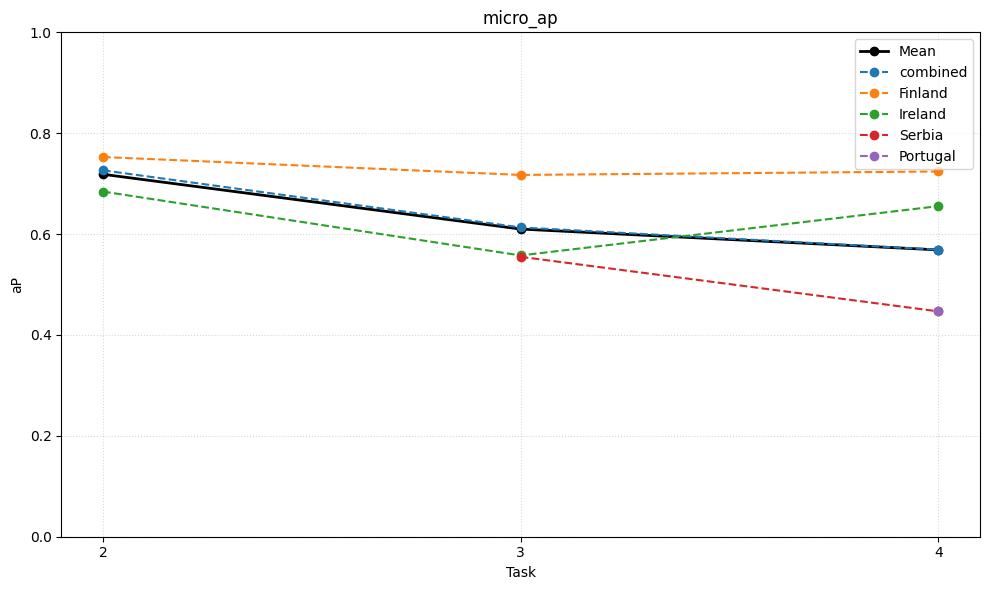

In [13]:
merge_path = "/home/anton/src/cl-lora/merge/log/pytorch_job_20250709_224652.log"
res = load_results_from_file(merge_path)
res = rename_task_to_step(res)

plot_accuracies_from_first(res,metric=mi)

In [12]:
def rename_task_to_step(results: list[dict]) -> None:
    """
    Mutate each dict in `results` by popping 'task' and
    inserting it back in as 'step'.

    After calling this, you can treat `step` exactly
    like in your other plotting code.
    """
    for record in results:
        # pop the old key, store as new key
        record['step'] = record.pop('task')

    return results

In [ ]:
rr_path = "/home/anton/src/cl-lora/baseline/log/task_tuning_epoch_20.log"
res_tt = load_results_from_file(rr_path)
plot_accuracies_from_first(res_tt,metric=mi)

In [ ]:
# results merging
res_merge = load_results_from_file("/home/anton/src/cl-lora/merge/log/pytorch_job_20250708_152552.log")

In [14]:
res_merge =rename_task_to_step(res_merge)


NameError: name 'res_merge' is not defined

In [ ]:
plot_accuracies_from_first(res_merge,metric=ma)

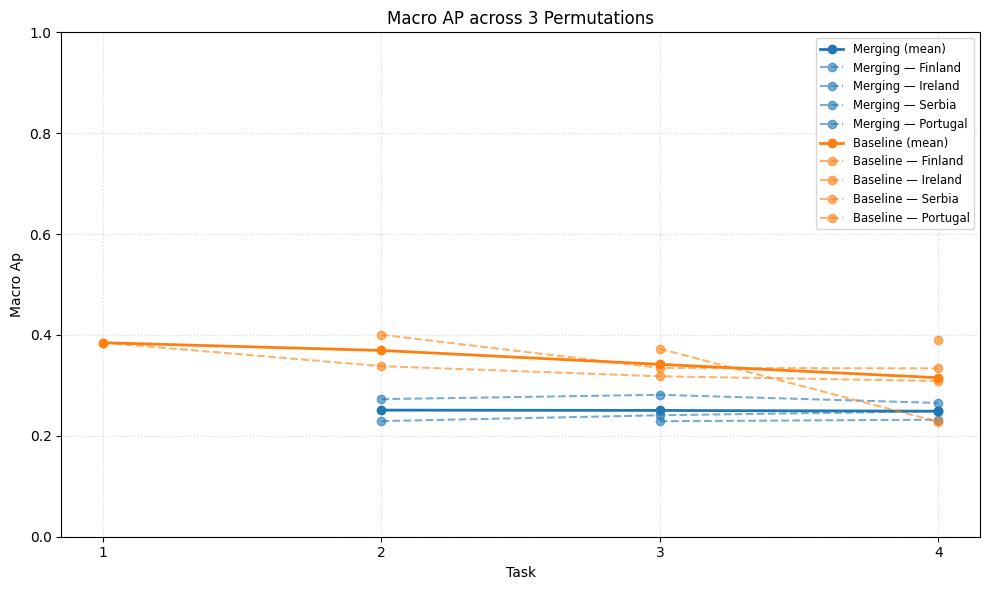

In [36]:
experiments = {
    'Merging': res,

    'Baseline':  load_results_from_file("/home/anton/src/cl-lora/baseline/log/epoch15/no_replay_0123.log"),


}
#     'R16': load_results_from_file("/home/anton/src/cl-lora/baseline/log/epoch20/rank16_no_replay_0123.log"),

# Just compare the mean accuracy curves:
#compare_experiments(experiments, 'accuracy')

# If you want to also see per‐country curves overlaid:
compare_experiments(experiments, ma, plot_countries=True,
                    title='Macro AP across 3 Permutations',
                    save_path='comparison_micro_ap.png',average=False)

In [17]:
res

[{'countries': ('Finland', 'Ireland'),
  'merge_time_s': 1549.1827557086945,
  'eval_time_s': 185.86198616027832,
  'num_tasks_merged': 2,
  'combined_micro_ap': 0.7263829776973987,
  'combined_macro_ap': 0.31888659311803846,
  'combined_accuracy': 91.725,
  'Finland_micro_ap': 0.752785991258321,
  'Finland_macro_ap': 0.27276222109715054,
  'Finland_accuracy': 91.84736842105264,
  'Ireland_micro_ap': 0.6842925804341828,
  'Ireland_macro_ap': 0.22922196643471504,
  'Ireland_accuracy': 91.60263157894737,
  'mean_micro_ap': 0.7185392858462519,
  'mean_macro_ap': 0.2509920937659328,
  'mean_accuracy': 91.725,
  'step': 2},
 {'countries': ('Finland', 'Ireland', 'Serbia'),
  'merge_time_s': 1547.775554895401,
  'eval_time_s': 278.1642920970917,
  'num_tasks_merged': 3,
  'combined_micro_ap': 0.6131567756687085,
  'combined_macro_ap': 0.357086652435786,
  'combined_accuracy': 88.80263157894737,
  'Finland_micro_ap': 0.7172719936115648,
  'Finland_macro_ap': 0.2813621287073468,
  'Finland_accu

In [18]:
def remove_combined_entries(data):
    """
    Given a list of dicts, return a new list where all keys beginning
    with 'combined_' have been removed from each dict.
    """
    cleaned = []
    for entry in data:
        cleaned_entry = {
            k: v
            for k, v in entry.items()
            if not k.startswith("combined_")
        }
        cleaned.append(cleaned_entry)
    return cleaned

In [30]:
res = remove_combined_entries(res)